This notebook explores the task of extracting social networks from text: for a given set of people mentioned in a text, can we extract a social network that connects them?  In this social network, people are the nodes, and the edges between them are weighted by the strength of their connection.

This notebook requires networkx; install with:

```sh
pip install networkx
```

In [1]:
!pip install networkx

In [2]:
import spacy
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt


In [3]:
nlp = spacy.load('en_core_web_sm', disable=['parser'])
nlp.add_pipe('sentencizer')

In [4]:
def process(filename):
    with open(filename, encoding="utf-8") as file:
        data=file.read()
        return nlp(data)

Pick an English-language book you know from [Project Gutenberg](https://www.gutenberg.org) and save it in the `data/` directory.  Read it in here.

In [6]:
# Chose the Great Gatsby
doc=process("/Users/melissalicari/Desktop/Project/data/gatsby.txt")

In [7]:
def get_people_mentions(doc, min_count=10):
    """ Extract all of the PERSON mentions in a spacy-processed document.
    Returns a dict mapping each unique person name to a list of spacy entity mentions
    Each spacy entity has the following attributes:
    
    * text
    * start position in document (character)
    * end position in document (character)
    * label (NER category)
    
    https://spacy.io/usage/linguistic-features#named-entities
    """
    people=defaultdict(list)
    for entity in doc.ents:
        if entity.label_ == "PERSON":
            people[entity.text.lstrip().rstrip()].append(entity)
    
    return people

In [8]:
def get_nodes(people, min_count=10):
    """ Creates network nodes from a dict of people mentions
    Input: a dict of people mentions returned from get_people_mentions()
    Output: a dict mapping the entity name to a positive numerical value of their importance 
    (the size of the node in a network graph)
    
    e.g., {"Tom": 5, "Huck": 1}
    
    """
    nodes=defaultdict(float)
    total=0.
    for person in people:
        if len(people[person]) >= min_count:
            nodes[person]=len(people[person])
            total+=len(people[person])
    
    for person in nodes:
        nodes[person]/=total
    
    return nodes

I am defining a social tie by how often two characters names are included in a sentence together. I will measure this by counting the amount of sentences in which pairs of characters names are mentioned in the same sentence.

In [9]:
def get_edges(people, doc):
    """ Creates network edges from a dict of people mentions and the full spacy-processed document
    Input: a dict of people mentions returned from get_people_mentions() and document returned from process()
    Output: a dict mapping a person all of the other people they are connected to, along with the weight of
    that connection.
    
    e.g., {"Tom: {"Huck": 2, "Sally": 1}, "Huck": {"Sally": 1}}
    
    Keep in mind that doc gives you access to *all* of the tokens in the book.
    
    """

    sentences = defaultdict(list)
    for person in people:
        for i in range(0,len(people[person])):
            sentences[person].append(people[person][i].sent)

    edges={}
    for person in people:
        if person not in edges:
            edges[person] = {}
            for person2 in people:
                if person2 not in edges[person]:
                    count = 0
                    if person != person2:
                        if any(i in sentences[person] for i in sentences[person2]):
                            count += 1
                        edges[person][person2] = count
        

    
    return edges

First, let's map *mentions* of character to the unique individuals they refer to. Say that every mention with exactly the same form refers to the same individual (so all mentions of "Elizabeth" refer to the character ELIZABETH, all mentions of "Mr. Darcy" refer to MR. DARCY, etc.)

In [10]:
people=get_people_mentions(doc)

Now we'll create nodes in a network from this list of person mentions by weighting each unique person name by its frequency of occurrence (corresponding to the intuition that more frequently mentioned characters are more important).

In [11]:
nodes=get_nodes(people)

Now we'll establish links between those nodes based on the operationalization within the `get_edges` function.

In [12]:
edges=get_edges(people, doc)

Let's visualize the network you've created.

In [13]:
def create_graph(nodes, edges):

    """ Plot a set of weighted nodes and weighted edges on a network graph """
    
    # increase this to expand network
    force_directed_expansion=2
    
    # increase these dimensions to make graph bigger
    figure_height=20
    figure_width=20
    
    G = nx.Graph()
    for person in nodes:
        G.add_node(person, nodesize=nodes[person])
    for person1 in edges:
        for person2 in edges[person1]:
            if person1 in nodes and person2 in nodes:
                G.add_weighted_edges_from([(person1, person2, edges[person1][person2]) ])

    options = {
    'edgecolors':"black",
    'linewidths':1,
    'with_labels': True,
    'font_weight': 'regular',
    }
    
    g_edges = G.edges()

    sizes = [G.nodes[node]['nodesize']*100000 for node in G]
    weights = [G[u][v]['weight']*10 for u,v in g_edges]

    fig, ax = plt.subplots(1, 1, figsize=(figure_height, figure_width));

    nx.draw_networkx(G, pos=nx.spring_layout(G, k=force_directed_expansion, iterations=100), node_size=sizes, width=weights, **options)

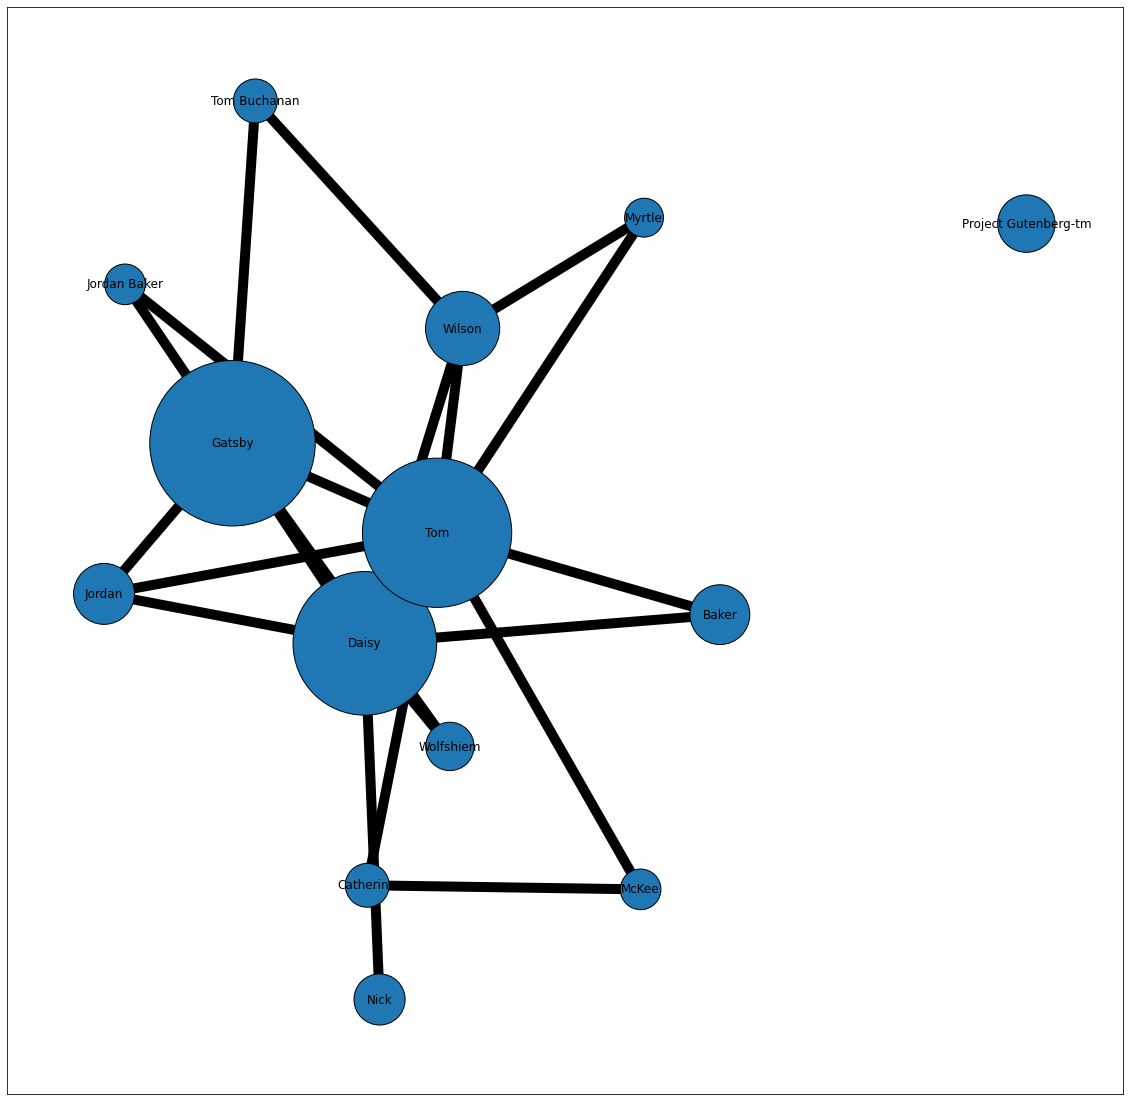

In [14]:
create_graph(nodes, edges)